# Understanding what drives prices of ride-hailing services
### Notebook 2


Antonio Montilla

Madrid, 15 November 2023

This notebook continues the analysis in 'Ride_hailing_prices_notebook1', focusing in objectives:

4) **Machine Learning Regression Modelling.** Utilize machine learning techniques to construct a regression model predicting ride-hailing prices based on selected features.
5) **Model Evaluation and Selection.** Compare different regression models for selecting the algorithm that best fit the dataset.
6) **Analyse Model Parameters and Conclude.** Investigate the weight and significance of each feature in the regression model. This analysis serves as compelling evidence for understanding how dynamic pricing mechanisms operate, offering valuable insights into the factors that exert the most influence on ride costs.


## Importing libraries

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import random as rnd
from pandas import read_csv
from scipy.stats import ttest_1samp #hypothesis testing

# Data visualization (note that this process will also be conducted in Tableau)
import seaborn as sns
from scipy.stats import norm, skew
from scipy import stats 
import matplotlib.pyplot as plt

#Data transformation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Machine learning
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

## Predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Importing the database

In [60]:
# Create the connection to the sql database uber_df in mysql
import pymysql
from sqlalchemy import create_engine
import getpass # To get the password without showing the input
password = getpass.getpass("Please enter the SQL database password: ")


Please enter the SQL database password: ········


In [63]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/project'
engine = create_engine(connection_string)

In [64]:
query1 = 'SELECT * FROM uber_df'
uber_df = pd.read_sql_query(query1, engine)
uber_df

,distance,destination,source,price,name,temp,clouds,pressure,rain,humidity,wind,datetime,day,hour,price_per_distance
0,1.11,entertaiment,commercial,12.0,UberXL,38.65,0.96,1017.23,0.0000,0.65,3.13,2018-11-30 22:13:01,4,22,10.810811
1,1.11,entertaiment,commercial,7.5,UberX,32.75,0.51,1033.75,0.0000,0.57,1.90,2018-12-13 19:15:04,3,19,6.756757
2,1.11,entertaiment,commercial,7.5,WAV,42.36,1.00,1012.15,0.2088,0.77,11.46,2018-12-16 23:55:11,6,23,6.756757
3,1.11,entertaiment,commercial,5.5,UberPool,42.48,0.58,1007.66,0.0000,0.54,10.84,2018-11-29 19:18:01,3,19,4.954955
4,2.48,business,entertaiment,8.5,WAV,40.00,0.82,999.92,0.0000,0.74,9.23,2018-12-17 20:40:10,0,20,3.427419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219402,1.61,commercial,entertaiment,15.0,WAV,37.01,0.83,1021.65,0.0000,0.85,1.60,2018-12-02 05:28:04,6,5,9.316770
219403,1.00,commercial,entertaiment,9.5,WAV,36.69,0.41,1023.64,0.0000,0.76,2.51,2018-12-01 23:53:06,5,23,9.500000
219404,1.00,commercial,entertaiment,13.0,UberXL,36.69,0.41,1023.64,0.0000,0.76,2.51,2018-12-01 23:53:06,5,23,13.000000
219405,1.00,commercial,entertaiment,9.5,UberX,36.69,0.41,1023.64,0.0000,0.76,2.51,2018-12-01 23:53:06,5,23,9.500000


In [6]:
display(uber_df.columns)
display(uber_df.dtypes)

Index(['distance', 'destination', 'source', 'price', 'name', 'temp', 'clouds',
       'pressure', 'rain', 'humidity', 'wind', 'datetime', 'day', 'hour',
       'price_per_distance'],
      dtype='object')

distance              float64
destination            object
source                 object
price                 float64
name                   object
temp                  float64
clouds                float64
pressure              float64
rain                  float64
humidity              float64
wind                  float64
datetime               object
day                     int64
hour                    int64
price_per_distance    float64
dtype: object

## Splitting the uber_df into Categorical and Numerical for data wrangling

In [7]:
numerical_df = uber_df.select_dtypes(np.number)
numerical_df

,distance,price,temp,clouds,pressure,rain,humidity,wind,day,hour,price_per_distance
0,1.11,12.0,38.65,0.96,1017.23,0.0000,0.65,3.13,4,22,10.810811
1,1.11,7.5,32.75,0.51,1033.75,0.0000,0.57,1.90,3,19,6.756757
2,1.11,7.5,42.36,1.00,1012.15,0.2088,0.77,11.46,6,23,6.756757
3,1.11,5.5,42.48,0.58,1007.66,0.0000,0.54,10.84,3,19,4.954955
4,2.48,8.5,40.00,0.82,999.92,0.0000,0.74,9.23,0,20,3.427419
...,...,...,...,...,...,...,...,...,...,...,...
219402,1.61,15.0,37.01,0.83,1021.65,0.0000,0.85,1.60,6,5,9.316770
219403,1.00,9.5,36.69,0.41,1023.64,0.0000,0.76,2.51,5,23,9.500000
219404,1.00,13.0,36.69,0.41,1023.64,0.0000,0.76,2.51,5,23,13.000000
219405,1.00,9.5,36.69,0.41,1023.64,0.0000,0.76,2.51,5,23,9.500000


In [8]:
categorical_df = uber_df.select_dtypes(object)
categorical_df

,destination,source,name,datetime
0,entertaiment,commercial,UberXL,2018-11-30 22:13:01.178999808
1,entertaiment,commercial,UberX,2018-12-13 19:15:03.935000064
2,entertaiment,commercial,WAV,2018-12-16 23:55:11.430000128
3,entertaiment,commercial,UberPool,2018-11-29 19:18:00.802000128
4,business,entertaiment,WAV,2018-12-17 20:40:09.832000000
...,...,...,...,...
219402,commercial,entertaiment,WAV,2018-12-02 05:28:04.148999936
219403,commercial,entertaiment,WAV,2018-12-01 23:53:05.533999872
219404,commercial,entertaiment,UberXL,2018-12-01 23:53:05.533999872
219405,commercial,entertaiment,UberX,2018-12-01 23:53:05.533999872


## Final Data Wrangling: categorical_df

In [9]:
#destination & source
display(categorical_df.destination.value_counts(dropna = False))
display(categorical_df.source.value_counts(dropna = False))
#will not make any changes to these columns

entertaiment    73038
business        54910
commercial      36620
education       36549
other           18290
Name: destination, dtype: int64

entertaiment    73101
business        54880
education       36573
commercial      36567
other           18286
Name: source, dtype: int64

In [10]:
#name
display(categorical_df.name.value_counts(dropna = False))
#will also leave this column as it is

UberXL      54859
UberPool    54856
WAV         54850
UberX       54842
Name: name, dtype: int64

In [11]:
#datetime: will delete this column as that information is redundant, in both uber_df & categorical_df
uber_df = uber_df.drop(['datetime'], axis = 1)
categorical_df = categorical_df.drop(['datetime'], axis = 1)

## Final Data Wrangling: numerical_df

In [12]:
numerical_df.columns

Index(['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity',
       'wind', 'day', 'hour', 'price_per_distance'],
      dtype='object')

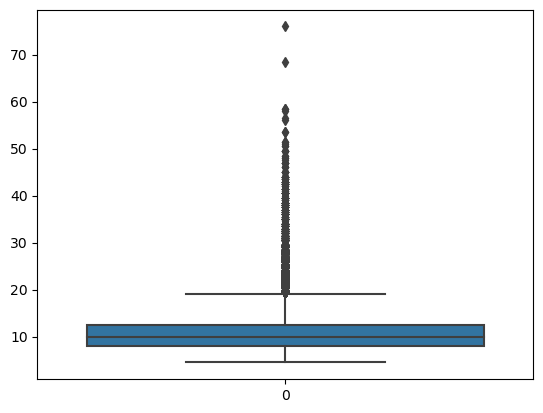

In [13]:
#price
sns.boxplot(numerical_df['price'])
plt.show()
#as this is the target column, I will not be making any changes.

In [14]:
#price_per_distance: as this will not be used in the model, I will drop it from both dataframes
uber_df = uber_df.drop(['price_per_distance'], axis = 1)
numerical_df = numerical_df.drop(['price_per_distance'], axis = 1)

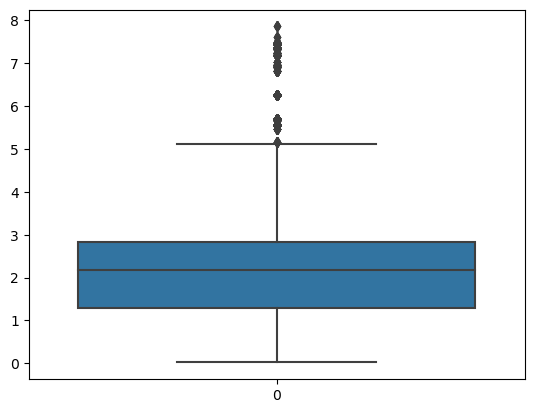

In [15]:
#distance
sns.boxplot(numerical_df['distance'])
plt.show()
#will not be making changes to this variable as based on previous analysis it has the strongest relation with price

In [16]:
#hour
#based on previous analisys I will regroup this column into the following categories: 
    #morning_rush: between 7-10am
    #afternoon_rush: between 4-7pm
    #other: the rest
def classify_hour(hour):
    if 7 <= hour < 10:
        return "morning_rush"
    elif 16 <= hour < 19:
        return "afternoon_rush"
    else:
        return "other"
    
numerical_df["hour"] = numerical_df["hour"].apply(classify_hour)
numerical_df.hour.value_counts(dropna = False)

other             165652
afternoon_rush     28891
morning_rush       24864
Name: hour, dtype: int64

In [17]:
#taking this column to categoricals and dropping from numericals
categorical_df['hour'] = numerical_df['hour']
numerical_df = numerical_df.drop(['hour'], axis = 1)

In [18]:
#day
#based on previous analysis I will regroup this column into the following categories: 
    #weekday: 0-3 (Monday-Thursday)
    #weekend: 4-5 (Friday-Saturday)
    #sunday: 6
display(numerical_df.day.value_counts(dropna = False))

def classify_day(day):
    if 0 <= day <= 3:
        return "weekday"
    elif 4 <= day <= 5:
        return "weekend"
    else:
        return "sunday"
    
numerical_df["day"] = numerical_df["day"].apply(classify_day)
numerical_df.day.value_counts(dropna = False)

0    39660
1    38882
3    31541
6    29020
4    28662
5    28509
2    23133
Name: day, dtype: int64

weekday    133216
weekend     57171
sunday      29020
Name: day, dtype: int64

In [19]:
#taking this column to categoricals and dropping from numericals
categorical_df['day'] = numerical_df['day']
numerical_df = numerical_df.drop(['day'], axis = 1)

,distance,price,temp,clouds,pressure,rain,humidity,wind
distance,1.000000,0.524711,-0.000591,0.002265,0.000326,-0.004082,-0.004365,-0.001811
price,0.524711,1.000000,0.000123,0.000855,-0.002029,-0.004299,-0.003937,0.000260
temp,-0.000591,0.000123,1.000000,0.437647,-0.374905,0.138127,0.371632,0.120369
clouds,0.002265,0.000855,0.437647,1.000000,-0.216931,0.212553,0.517552,0.130146
pressure,0.000326,-0.002029,-0.374905,-0.216931,1.000000,-0.071385,-0.144258,-0.575606
rain,-0.004082,-0.004299,0.138127,0.212553,-0.071385,1.000000,0.216579,0.236081
humidity,-0.004365,-0.003937,0.371632,0.517552,-0.144258,0.216579,1.000000,-0.200745
wind,-0.001811,0.000260,0.120369,0.130146,-0.575606,0.236081,-0.200745,1.000000


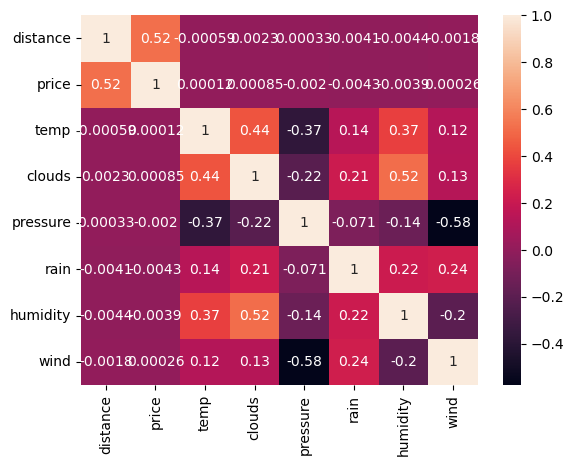

In [20]:
#finally for the weather data, I will first see the correlation matrix
correlations_matrix = numerical_df.corr()
display(correlations_matrix)
sns.heatmap(correlations_matrix, annot=True)
plt.show()

- The correlation matrix confirms that the weather columns have indeed a relatively weak relationship with the target variable.
- However, some of these columns do show strong correlation between each others.
- Based on the high correlation and in my previous analysis, I decide to only keep for the model 'temp', 'rain' and 'wind'.

In [21]:
#dropping 'clouds', 'pressure', 'humidity', in both numeric_df & uber_df:
numerical_df = numerical_df.drop(['clouds', 'pressure', 'humidity'], axis = 1)
uber_df = uber_df.drop(['clouds', 'pressure', 'humidity'], axis = 1)

## Processing Data

In [22]:
#concatenating numerical_df & categorical_df
uber_df_clean = pd.concat([numerical_df, categorical_df], axis=1)
uber_df_clean

,distance,price,temp,rain,wind,destination,source,name,hour,day
0,1.11,12.0,38.65,0.0000,3.13,entertaiment,commercial,UberXL,other,weekend
1,1.11,7.5,32.75,0.0000,1.90,entertaiment,commercial,UberX,other,weekday
2,1.11,7.5,42.36,0.2088,11.46,entertaiment,commercial,WAV,other,sunday
3,1.11,5.5,42.48,0.0000,10.84,entertaiment,commercial,UberPool,other,weekday
4,2.48,8.5,40.00,0.0000,9.23,business,entertaiment,WAV,other,weekday
...,...,...,...,...,...,...,...,...,...,...
219402,1.61,15.0,37.01,0.0000,1.60,commercial,entertaiment,WAV,other,sunday
219403,1.00,9.5,36.69,0.0000,2.51,commercial,entertaiment,WAV,other,weekend
219404,1.00,13.0,36.69,0.0000,2.51,commercial,entertaiment,UberXL,other,weekend
219405,1.00,9.5,36.69,0.0000,2.51,commercial,entertaiment,UberX,other,weekend


#### Splitting in X and Y

In [23]:
X = uber_df_clean.drop(['price'],axis=1)
y = uber_df_clean['price']

#### Splitting into train & test:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

#### Creating X_train_num & X_test_num

In [25]:
X_train_num = X_train.select_dtypes(np.number)
X_test_num = X_test.select_dtypes(np.number)
X_train_num

,distance,temp,rain,wind
7941,3.16,41.650000,0.0,6.200000
10748,2.46,40.930000,0.0,1.800000
36738,1.57,37.450000,0.0,9.752222
58872,1.34,40.690000,0.0,6.630000
40021,2.30,33.400000,0.0,5.948750
...,...,...,...,...
143967,2.30,40.300000,0.0,9.730000
60960,3.30,37.503333,0.0,6.690000
137084,0.91,38.738571,0.0,10.485714
194179,2.63,46.880000,0.0,3.890000


#### Scaling X_train_num

In [26]:
from sklearn.preprocessing import MinMaxScaler
MinMaxtransformer = MinMaxScaler().fit(X_train_num)
x_standardized = MinMaxtransformer.transform(X_train_num)
print(x_standardized.shape)
X_train_num_s = pd.DataFrame(x_standardized, columns=X_train_num.columns)
X_train_num_s

(175525, 4)


,distance,temp,rain,wind
0,0.400510,0.615535,0.0,0.329978
1,0.311224,0.595418,0.0,0.083893
2,0.197704,0.498184,0.0,0.528648
3,0.168367,0.588712,0.0,0.354027
4,0.290816,0.385024,0.0,0.315926
...,...,...,...,...
175520,0.290816,0.577815,0.0,0.527405
175521,0.418367,0.499674,0.0,0.357383
175522,0.113520,0.534188,0.0,0.569671
175523,0.332908,0.761665,0.0,0.200783


#### Using trained scaler to scale X_test_num

In [27]:
x_standardized = MinMaxtransformer.transform(X_test_num)
print(x_standardized.shape)
X_test_num_s = pd.DataFrame(x_standardized, columns=X_test_num.columns)
X_test_num_s

(43882, 4)


,distance,temp,rain,wind
0,0.149235,0.531713,0.0000,0.616331
1,0.343112,0.475272,0.0000,0.043065
2,0.114796,0.523610,0.0000,0.431767
3,0.276786,0.180497,0.0000,0.140380
4,0.139031,0.378970,0.0000,0.304251
...,...,...,...,...
43877,0.405612,0.383068,0.0000,0.718680
43878,0.197704,0.283599,0.0000,0.092841
43879,0.311224,0.377154,0.0000,0.299497
43880,0.153061,0.865605,0.0000,0.206376


#### Creating X_train_cat & X_test_cat

In [28]:
X_train_cat = X_train.select_dtypes(object)
X_test_cat = X_test.select_dtypes(object)
X_train_cat

,destination,source,name,hour,day
7941,commercial,entertaiment,UberPool,other,sunday
10748,entertaiment,other,UberX,other,weekend
36738,commercial,entertaiment,WAV,other,weekday
58872,business,commercial,UberX,other,sunday
40021,entertaiment,commercial,WAV,morning_rush,weekday
...,...,...,...,...,...
143967,entertaiment,commercial,UberX,other,weekday
60960,education,business,WAV,other,weekday
137084,entertaiment,commercial,WAV,other,weekday
194179,entertaiment,education,UberX,other,weekend


#### One-hot encoding X_train_cat

In [29]:
encoder = OneHotEncoder(drop='first').fit(X_train_cat)
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
encoded = encoder.transform(X_train_cat).toarray()
X_train_cat_onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_train_cat_onehot_encoded 

,destination_commercial,destination_education,destination_entertaiment,destination_other,source_commercial,source_education,source_entertaiment,source_other,name_UberX,name_UberXL,name_WAV,hour_morning_rush,hour_other,day_weekday,day_weekend
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175520,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
175521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
175522,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
175523,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


#### One-hot encoding X_test_cat

In [30]:
encoded = encoder.transform(X_test_cat).toarray()
X_test_cat_onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_test_cat_onehot_encoded 

,destination_commercial,destination_education,destination_entertaiment,destination_other,source_commercial,source_education,source_entertaiment,source_other,name_UberX,name_UberXL,name_WAV,hour_morning_rush,hour_other,day_weekday,day_weekend
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43877,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
43878,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
43879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
43880,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Concatenating X_train from X_train_num_s & X_train_cat_onehot_encoded 

In [31]:
X_train = pd.concat([X_train_num_s, X_train_cat_onehot_encoded], axis=1)
display(X_train.dtypes)
X_train

distance                    float64
temp                        float64
rain                        float64
wind                        float64
destination_commercial      float64
destination_education       float64
destination_entertaiment    float64
destination_other           float64
source_commercial           float64
source_education            float64
source_entertaiment         float64
source_other                float64
name_UberX                  float64
name_UberXL                 float64
name_WAV                    float64
hour_morning_rush           float64
hour_other                  float64
day_weekday                 float64
day_weekend                 float64
dtype: object

,distance,temp,rain,wind,destination_commercial,destination_education,destination_entertaiment,destination_other,source_commercial,source_education,source_entertaiment,source_other,name_UberX,name_UberXL,name_WAV,hour_morning_rush,hour_other,day_weekday,day_weekend
0,0.400510,0.615535,0.0,0.329978,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.311224,0.595418,0.0,0.083893,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.197704,0.498184,0.0,0.528648,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.168367,0.588712,0.0,0.354027,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.290816,0.385024,0.0,0.315926,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175520,0.290816,0.577815,0.0,0.527405,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
175521,0.418367,0.499674,0.0,0.357383,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
175522,0.113520,0.534188,0.0,0.569671,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
175523,0.332908,0.761665,0.0,0.200783,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


#### Repeting for X_Test

In [32]:
X_test = pd.concat([X_test_num_s, X_test_cat_onehot_encoded], axis=1)
display(X_test.dtypes)
X_test

distance                    float64
temp                        float64
rain                        float64
wind                        float64
destination_commercial      float64
destination_education       float64
destination_entertaiment    float64
destination_other           float64
source_commercial           float64
source_education            float64
source_entertaiment         float64
source_other                float64
name_UberX                  float64
name_UberXL                 float64
name_WAV                    float64
hour_morning_rush           float64
hour_other                  float64
day_weekday                 float64
day_weekend                 float64
dtype: object

,distance,temp,rain,wind,destination_commercial,destination_education,destination_entertaiment,destination_other,source_commercial,source_education,source_entertaiment,source_other,name_UberX,name_UberXL,name_WAV,hour_morning_rush,hour_other,day_weekday,day_weekend
0,0.149235,0.531713,0.0000,0.616331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.343112,0.475272,0.0000,0.043065,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.114796,0.523610,0.0000,0.431767,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.276786,0.180497,0.0000,0.140380,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.139031,0.378970,0.0000,0.304251,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43877,0.405612,0.383068,0.0000,0.718680,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
43878,0.197704,0.283599,0.0000,0.092841,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
43879,0.311224,0.377154,0.0000,0.299497,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
43880,0.153061,0.865605,0.0000,0.206376,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Modelling

#### Defining a function to run all models

In [33]:
def models_automation(models, X_tr, y_tr,X_te, y_te):
    R_score_train = []
    R_score_test = []
    for model in models:
        model.fit(X_tr, y_tr)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")
        R_score_train.append(model.score(X_tr, y_tr))
        R_score_test.append(model.score(X_te, y_te))
    column_names=["R_score_train","R_score_test"]
    results = pd.DataFrame({'R_score_train': R_score_train, 'R_score_test': R_score_test})
    return results

#### Running models

In [34]:
model_list = [LinearRegression(),SGDRegressor(),KNeighborsRegressor(), MLPRegressor(),DecisionTreeRegressor(),RandomForestRegressor()]
results = models_automation(model_list, X_train, y_train,X_test, y_test)

LinearRegression: Train -> 0.7232272656792417, Test -> 0.7309039161049455
SGDRegressor: Train -> 0.722868236563501, Test -> 0.7308025283921086
KNeighborsRegressor: Train -> 0.8209910168448811, Test -> 0.7398584016168441
MLPRegressor: Train -> 0.7774007090735757, Test -> 0.782761584096926
DecisionTreeRegressor: Train -> 0.9356394841123946, Test -> 0.6204652786584184
RandomForestRegressor: Train -> 0.9175611032149635, Test -> 0.7447629866969541


In [35]:
results['Model'] = model_list
results['Model'] = results['Model'].astype(str).str.split('(').str[0]
display(results.dtypes)
results

R_score_train    float64
R_score_test     float64
Model             object
dtype: object

,R_score_train,R_score_test,Model
0,0.723227,0.730904,LinearRegression
1,0.722868,0.730803,SGDRegressor
2,0.820991,0.739858,KNeighborsRegressor
3,0.777401,0.782762,MLPRegressor
4,0.935639,0.620465,DecisionTreeRegressor
5,0.917561,0.744763,RandomForestRegressor


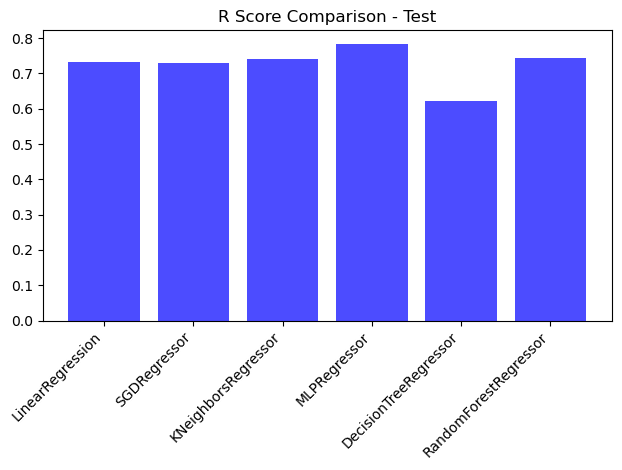

In [36]:
# Plotting R_score_test
plt.bar(results['Model'], results['R_score_test'], color='blue', alpha=0.7, label='R_score_test')
plt.title('R Score Comparison - Test')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

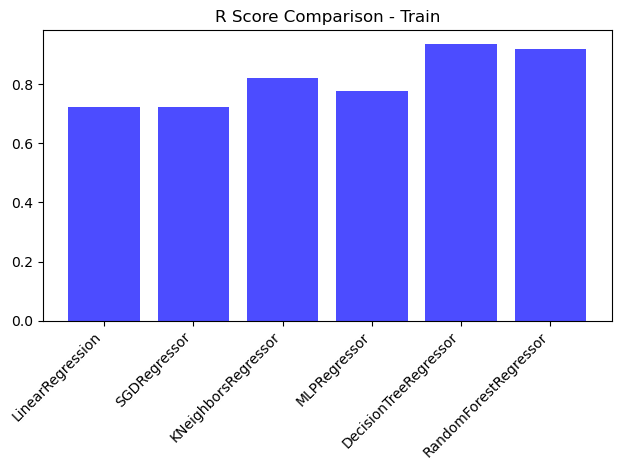

In [37]:
# Plotting R_score_train
plt.bar(results['Model'], results['R_score_train'], color='blue', alpha=0.7, label='R_score_train')
plt.title('R Score Comparison - Train')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

#### Model observations and decisions:
- After testing different regression algorithms, the model that best fit the data is the MLPRegressor, with a R score in the test sample of 0.78
- I will now focus on this model and calculate all the evaluation paremerts.
- As a further step, as MLPRegressors do not have function to display the coefficients of the explanatory variables, I will also built  a linear regression model to see the coefficient by each X.
- The latter step will allow to disclose the effect of each X column for explaning price.

In [38]:
#saving the MLPRegressor model
model = MLPRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
score_test = model.score(X_test, y_test)
score_train = model.score(X_train, y_train)
mse=mean_squared_error(y_test,predictions)
rmse = np.sqrt(mean_squared_error(y_test,predictions))

In [39]:
print("The R_score_test for MLPRegressor is", score_test)
print("The R_score_train for MLPRegressor is", score_train)
print("The MSE for MLPRegressor is",mse)
print("The RMSE for MLPRegressor is",rmse)

The R_score_test for MLPRegressor is 0.7808235270380411
The R_score_train for MLPRegressor is 0.7752902341288578
The MSE for MLPRegressor is 3.6000839730253698
The RMSE for MLPRegressor is 1.8973887248071677


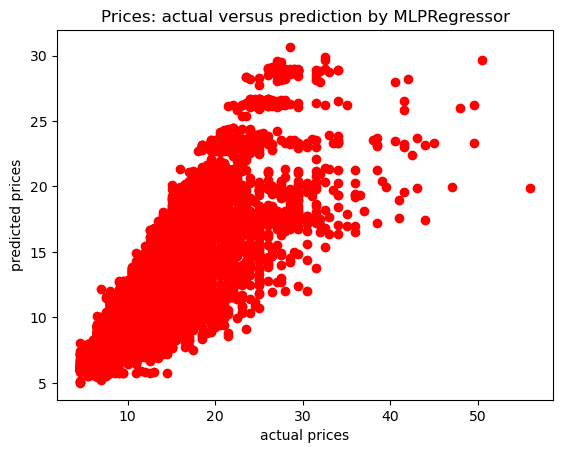

In [40]:
plt.figure()
plt.scatter(y_test,predictions, marker = 'o', color='red')
plt.xlabel('actual prices')
plt.ylabel('predicted prices')
plt.title('Prices: actual versus prediction by MLPRegressor')
plt.show()

#### Buliding a linear regression model to understand coefficients of X_test

In [41]:
model2 = LinearRegression()
model2.fit(X_train,y_train)
predictions2 = model2.predict(X_test)
score_test = model2.score(X_test, y_test)
score_train = model2.score(X_train, y_train)
mse=mean_squared_error(y_test,predictions2)
rmse = np.sqrt(mean_squared_error(y_test,predictions2))

In [42]:
print("The R_score_test for LinearRegression is", score_test)
print("The R_score_train for LinearRegression is", score_train)
print("The MSE for LinearRegression is",mse)
print("The RMSE for LinearRegression is",rmse)

The R_score_test for LinearRegression is 0.7309039161049455
The R_score_train for LinearRegression is 0.7232272656792417
The MSE for LinearRegression is 4.420038728347541
The RMSE for LinearRegression is 2.102388814740875


,coef
category,
distance,14.859448
name_UberXL,6.933854
name_UberX,1.006402
name_WAV,1.005131
source_commercial,0.354552
destination_education,0.220442
destination_commercial,0.216503
destination_entertaiment,0.168176
source_entertaiment,0.099472


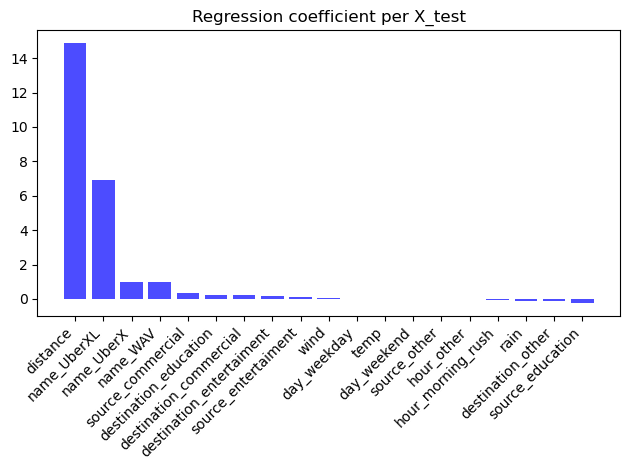

In [71]:
coeff_df = (pd.DataFrame({'coef':model2.coef_, 'category':X_test.columns})
.sort_values(by = 'coef', ascending = False)
.set_index('category'))
display(coeff_df)
# Plotting coeff_df
plt.bar(coeff_df.index, coeff_df['coef'], color='blue', alpha=0.7, label='Coefficient')
plt.title('Regression coefficient per X_test')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()
plt.show()

- As expected, the model score is mainly attributed to the effect of 'distance' and to a lesser extend to the type of service (e.g.'UberXL', 'UberX') and some locations as destinations.
- The time of the day or week nor the weather columns seem to be very relevant in explaning prices.

#### Testing alternative models only with 'distance', 'name_UberXL', 'name_UberX' and 'name_WAV' as regressors.
- As a final step, I will build a model using MLPRegressor and LinearRegresssor using only the four most relevant columns with 'distance', 'name_UberXL', 'name_UberX', 'name_WAV.
- I will then compare these results with those obtained previously.

In [44]:
#creating X_train2 & X_test2
X_train2 = X_train[['distance', 'name_UberXL', 'name_UberX', 'name_WAV']]
X_train2
X_test2 = X_test[['distance', 'name_UberXL', 'name_UberX', 'name_WAV']]
X_test2

,distance,name_UberXL,name_UberX,name_WAV
0,0.149235,0.0,1.0,0.0
1,0.343112,0.0,0.0,1.0
2,0.114796,0.0,0.0,0.0
3,0.276786,0.0,0.0,0.0
4,0.139031,0.0,0.0,0.0
...,...,...,...,...
43877,0.405612,0.0,1.0,0.0
43878,0.197704,1.0,0.0,0.0
43879,0.311224,1.0,0.0,0.0
43880,0.153061,1.0,0.0,0.0


In [45]:
#using linear regression 
model3 = LinearRegression()
model3.fit(X_train2,y_train)
predictions2 = model3.predict(X_test2)
score_test = model3.score(X_test2, y_test)
score_train = model3.score(X_train2, y_train)
mse=mean_squared_error(y_test,predictions2)
rmse = np.sqrt(mean_squared_error(y_test,predictions2))

In [46]:
print("The R_score_test for LinearRegression2 is", score_test)
print("The R_score_train for LinearRegression2 is", score_train)
print("The MSE for LinearRegressionr2 is",mse)
print("The RMSE for LinearRegression2 is",rmse)

The R_score_test for LinearRegression2 is 0.7284978308340737
The R_score_train for LinearRegression2 is 0.7211094385057168
The MSE for LinearRegressionr2 is 4.459559890926437
The RMSE for LinearRegression2 is 2.111767006780444


In [47]:
#using MLPRegressor
model4 = MLPRegressor()
model4.fit(X_train2,y_train)
predictions2 = model4.predict(X_test2)
score_test = model4.score(X_test2, y_test)
score_train = model4.score(X_train2, y_train)
mse=mean_squared_error(y_test,predictions2)
rmse = np.sqrt(mean_squared_error(y_test,predictions2))

In [48]:
print("The R_score_test for MLPRegressor2 is", score_test)
print("The R_score_train for MLPRegressor2 is", score_train)
print("The MSE for MLPRegressor2 is",mse)
print("The RMSE for MLPRegressor2 is",rmse)

The R_score_test for MLPRegressor2 is 0.7719641323333181
The R_score_train for MLPRegressor2 is 0.7651140526430924
The MSE for MLPRegressor2 is 3.7456039937472805
The RMSE for MLPRegressor2 is 1.9353562963308024


- As expected, the R scores or the RMSE of both the LinearRegressor2 and the MLPRegressor2 barely changes with the models when all explanatory variables are included.
- It is therefore possible to conclude that mostly the distance and the type of service provided will be the key factors influencing prices in Uber.

## Conclusions, caveats and further analysis.
- The aim of this project was to analyse and identify the main factors behind the pricing strategy of ride-hailing companies, using a dataset for Uber and Lyft trips provided in a Kaggle challenge.
- As shown throughout the analysis, distance is by the far the most influencing factor in the estimated price of ride-hailing services, a factor that is indeed the fundamental input that Uber identifies when disclosing how it sets its standard rates.
- Other factors that have some relevance in prices are also the type of service chosen in the App, for example if the request is for a wheelchair-accessible vehicle or for a large car (XL).
- However, the analysis also showed that the price per mile set by Uber could be incremented during periods of high demand, relative to the number of available drivers (using a dynamic pricing algorithm).
- For example, in morning rush hours, there is evidence that the average price per mile could be 15% higher relative to the average price per mile in the overall database. In afternoon rush hours or during the weekend, there is also some evidence of higher average prices. By contrast, except during very extreme circumstances, there was little evidence to suggest that weather conditions significantly affect prices.
- Overall, prices get incremented relative to standard rates only in a relatively small share of the observations (for the Lyft database, dynamic pricing took place only in 7% of total rides).
- There a number of caveats, however, to highlight in this analysis. First, and mostly, the data used in this project was taken for only 1 week in 12 districts of the city of Boston and therefore is unlikely to be representative of the overall distribution of prices set by these companies throughout the year.
- Furthermore, the data account only for simulated requested trips made through the Uber and Lyft APIs by the same user, where only very limited amount of information was able to be collected. Moreover, the fact that the trip requests were made by the same user does not allow to analyse the potential effect on prices from customer profiling. 
- Given all of the above, it is very likely that other factors are indeed at play in setting prices for ride-hailing services. At the very least, further analysis will require a recollection of data using different users, for a longer period of time and involving a larger number of geographic locations. 